<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Pancake demo
#### Gator Glaciology Lab, University of Florida

Simulation of pancake image

In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import ticker
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import GStatSim as gs
from skimage.io import imread

(2000, 2000)


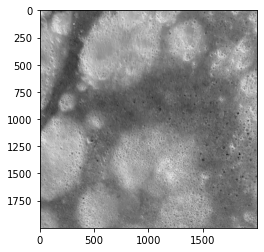

In [2]:
gray = imread('Images/pancake.jpg', as_gray=True)
gray = gray[:2000,:2000]
print(gray.shape)

plt.imshow(gray, cmap='gray')
plt.show()

In [3]:
# make x,y coordinates
x = np.arange(gray.shape[1])
y = np.arange(gray.shape[0])
xx, yy = np.meshgrid(x, y)

In [4]:
# make dataframe of data
data = np.dstack([xx, yy, gray]).reshape(x.shape[0]*y.shape[0],3)
df = pd.DataFrame(data=data, columns=['X', 'Y', 'Z'])

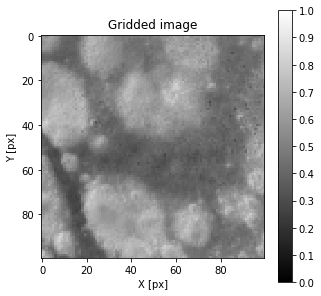

In [5]:
# smooth the data to a coarser grid (to speed up computational time)
res = 20 # resolution
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df, 'X', 'Y', 'Z', res)
df_grid = df_grid.rename(columns = {"Z": "Pancake"})

# plot gridded bed
plt.figure(figsize=(5,5))
im = plt.imshow(grid_matrix, cmap='gray', interpolation='none', vmin = 0, vmax = 1, origin='upper')
plt.title('Gridded image')
plt.xlabel('X [px]'); plt.ylabel('Y [px]')
ax = plt.gca()
ax.axis('scaled')
cbar = plt.colorbar(im, ticks=np.linspace(0, 1, 11))
plt.show()

In [6]:
# generate n random indices
n_points = 400

rng = default_rng()
ridxs = rng.choice(df_grid.shape[0], n_points)

df_samp = df_grid.iloc[ridxs]

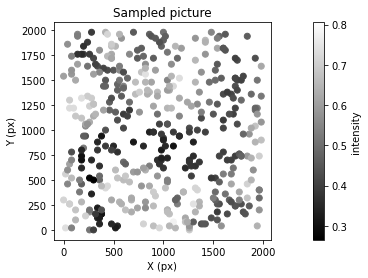

In [7]:
plt.scatter(df_samp.X, df_samp.Y, c=df_samp.Pancake, cmap='gray')
plt.colorbar(label='intensity')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.title('Sampled picture')
plt.axis('scaled')
plt.show()

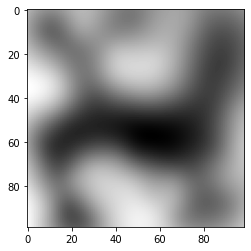

In [8]:
# compute trend
smooth_radius = 250 # smoothing radius for RBF function (100 km)
df_samp_grid, samp_grid_matrix, rows, cols = gs.Gridding.grid_data(df_samp, 'X', 'Y', 'Pancake', res)
trend_rbf = gs.rbf_trend(samp_grid_matrix, smooth_radius, res)

plt.imshow(trend_rbf, cmap='gray')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

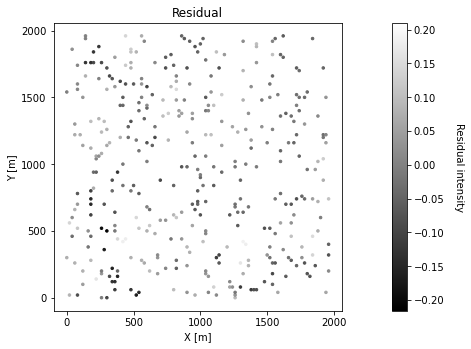

In [9]:
# subtract trend from data
diff = samp_grid_matrix - trend_rbf
diff = np.flipud(diff) # flip matrix

# remove NaNs, add to dataframe
ny, nx = diff.shape
diff_array = np.reshape(diff,[ny*nx])
diff_array = diff_array[~np.isnan(diff_array)]
df_samp_grid = df_samp_grid[df_samp_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_samp_grid = df_samp_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency
df_samp_grid['Residual'] = diff_array

# plot residual 
fig = plt.figure()
im = plt.scatter(df_samp_grid['X'],df_samp_grid['Y'], c = df_samp_grid['Residual'], marker=".", s = 25, 
                 cmap = 'gray')       # scatter plot for location map
plt.title('Residual')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical") # add vertical color bar
cbar.set_label("Residual intensity", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

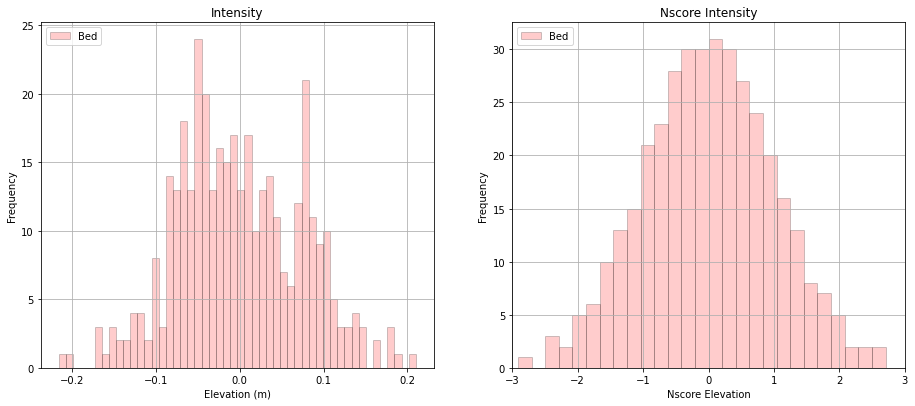

In [10]:
# normal score transformation
data = df_samp_grid['Residual'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=200, output_distribution="normal").fit(data)
df_samp_grid['Nscore'] = nst_trans.transform(data) 

plt.subplot(121)                                        # plot original bed histogram
plt.hist(df_samp_grid['Residual'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlabel('Elevation (m)'); plt.ylabel('Frequency'); plt.title('Intensity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot normal score bed histogram (with weights)
plt.hist(df_samp_grid['Nscore'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlim([-3.0,3.0]); 
plt.xlabel('Nscore Elevation'); plt.ylabel('Frequency'); plt.title('Nscore Intensity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

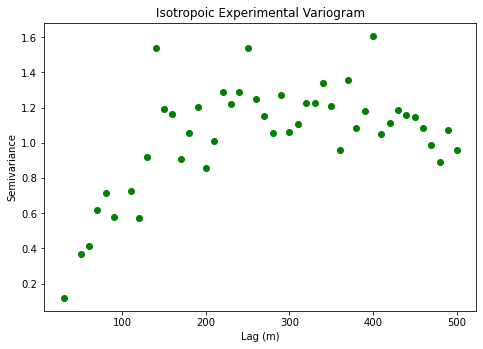

In [11]:
# compute experimental (isotropic) variogram
coords = df_samp_grid[['X','Y']].values
values = df_samp_grid['Nscore']

maxlag = 500 # maximum range distance
n_lags = 50 #num of bins

# compute variogram
V0 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

# extract variogram values
xdata = V0.bins
ydata = V0.experimental

plt.plot(xdata,ydata,'og')
plt.title('Isotropoic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1) # adjust the plot size

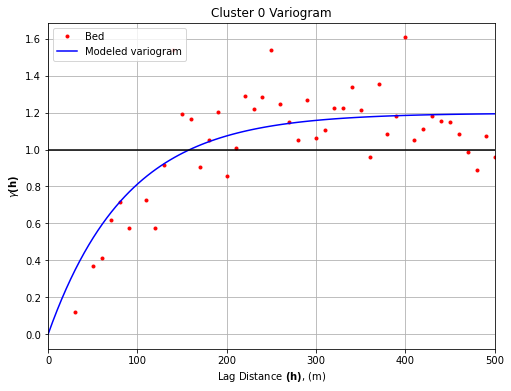

In [12]:
V0.model = 'exponential'

# fit variogram model

V0.model = 'exponential' # use exponential variogram model

n = 100
lagh = np.linspace(0,500,n) # create array of evenly spaced lag values to evaluate

range0 = V0.parameters[0]; sill0 = V0.parameters[1]

y0 = [models.exponential(h, range0, sill0, 0) for h in lagh]

plt.figure(figsize=(8,6))
plt.plot(V0.bins,V0.experimental,'.',color = 'red',label = 'Bed')
plt.plot(lagh,y0,'-',color = 'blue',label = 'Modeled variogram')
plt.plot([0,500],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 0 Variogram')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim([0,500])
plt.show()

In [13]:
# define coordinate grid
res = 20
xmin = np.min(df_samp_grid['X']); xmax = np.max(df_samp_grid['X'])     # min and max x values
ymin = np.min(df_samp_grid['Y']); ymax = np.max(df_samp_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [14]:
# set variogram parameters
azimuth = 0
nug = V0.parameters[2]
a_maj = V0.parameters[0]
a_min = V0.parameters[0]
sill = V0.parameters[1] 
vario = [azimuth, nug, a_maj, a_min, sill] # save variogram parameters as a list

k = 24 # number of neighboring data points used to estimate a given point 
rad = 500 

sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_samp_grid, 'X', 'Y', 'Nscore', k, vario, rad) 

100%|██████████████████████████████████████| 9801/9801 [00:56<00:00, 173.42it/s]


(-98.0, 2058.0, -98.0, 2058.0)

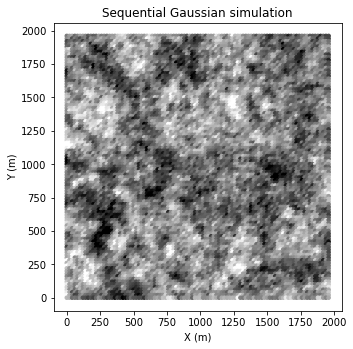

In [15]:
# plot simulation

im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sim, vmin = -3, vmax = 3, marker=".", s = 50,
                cmap = 'gray')       # scatter plot for location map
plt.title('Sequential Gaussian simulation')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

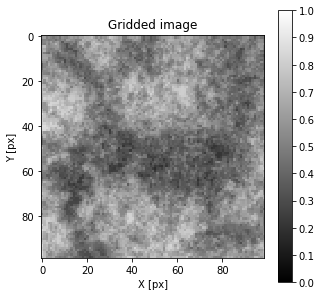

In [16]:
# reverse normal score transformation
sim1 = sim.reshape(-1,1)
sim1 = nst_trans.inverse_transform(sim1)

# reshape
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
sim_mat = sim1.reshape((rows, cols))

# add trend
sim_tot = sim_mat + trend_rbf

# plot gridded bed
plt.figure(figsize=(5,5))
im = plt.imshow(sim_tot, cmap='gray', interpolation='none', vmin = 0, vmax = 1, origin='upper')
plt.title('Gridded image')
plt.xlabel('X [px]'); plt.ylabel('Y [px]')
ax = plt.gca()
ax.axis('scaled')
cbar = plt.colorbar(im, ticks=np.linspace(0, 1, 11))
plt.show()